## Importing data and libraries

In [1]:
# Import necessary libraries
from google.cloud import bigquery
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from textblob import TextBlob
from collections import Counter
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from sklearn.decomposition import LatentDirichletAllocation
import nltk
from nltk.corpus import stopwords
import requests
from tabulate import tabulate


In [2]:
# Initialize a BigQuery client
client = bigquery.Client(project='container-testing-381309')

# Function to execute BigQuery and return results as a DataFrame
def run_bigquery(query):
    query_job = client.query(query)
    return query_job.to_dataframe()

# Read user_info table
user_info_query = """
SELECT *
FROM `container-testing-381309.telegram.user_info`
"""
user_info_df = run_bigquery(user_info_query)

# Read chat_history table
chat_history_query = """
SELECT *
FROM `container-testing-381309.telegram.chat_history`
"""
chat_history_df = run_bigquery(chat_history_query)

# Read chat_info table
chat_info_query = """
SELECT *
FROM `container-testing-381309.telegram.chat_info`
"""

chat_info_df = run_bigquery(chat_info_query)

#before fixing this in ETL logic, chat history was automatically adding a -100 prefix to chat_id
#To have identical chat_id in all tables, we need to remove this prefix from chat_id in chat_history table
# Remove the "-100" prefix from chat_id
chat_history_df['id'] = chat_history_df['id'].apply(lambda x: str(x)[4:] if str(x).startswith('-100') else str(x))
chat_history_df['id'] = chat_history_df['id'].astype(int)

# Merge the chat_info table to get chat names
chat_history_df = chat_history_df.merge(chat_info_df, on='id', how='left')

print(chat_history_df.head())


# Merge the chat_info table to get chat names
#chat_history_df = chat_history_df.merge(chat_info_df[['id', 'name', 'username']], left_on='chat_id', right_on='id', how='left')

# Fill in the chat name with the username if the name is missing
#chat_history_df['chat_name'] = chat_history_df['name'].fillna(chat_history_df['username'])

# Replace the chat_id with the chat name
#chat_history_df['chat_id'] = chat_history_df['chat_name']

         id                      date   from_user  \
0  17719997 2024-08-19 04:00:11+00:00   210944655   
1  17719990 2024-08-19 03:57:34+00:00  6964874762   
2  17719989 2024-08-19 03:57:31+00:00   971143551   
3  17719899 2024-08-19 03:15:58+00:00  7352813190   
4  17719895 2024-08-19 03:14:33+00:00  1138016036   

                                                text      sender     chat_id  \
0  Hello, Mr Goaldigger - [`7093270443`] and welc...   210944655  1146170349   
1  We currently do not have data for TON. Please ...  6964874762  1146170349   
2                                         /price ton   971143551  1146170349   
3                                            Wuhuuuu  7352813190  1146170349   
4             dogs listed any chance form Binance???  1138016036  1146170349   

   is_reply  views  forwards  replies  ... edit_date via_bot  reply_to_msg_id  \
0     False      0         0        0  ...       0.0       0                0   
1     False      0         0        0 

## Analysis of different statistics

Message activity over time

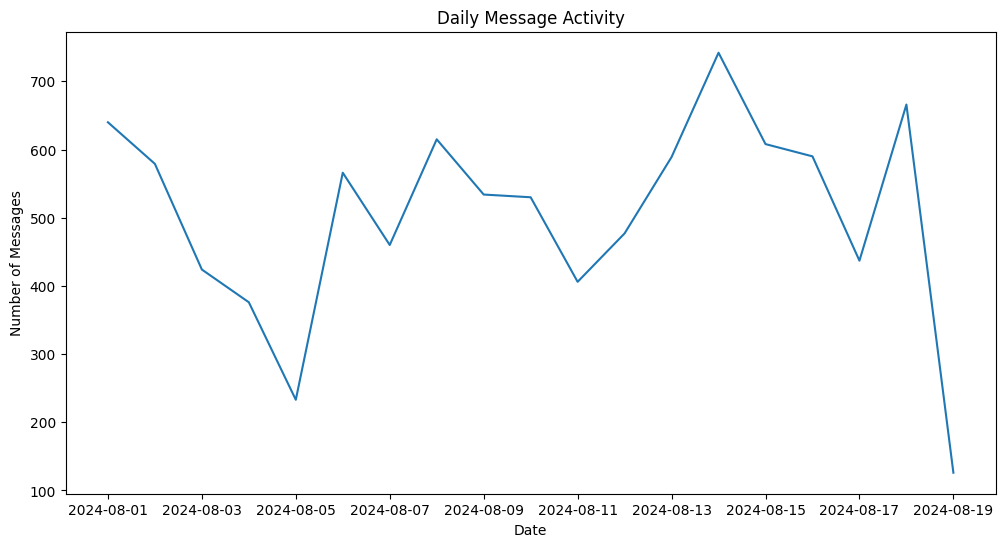

In [3]:
chat_history_df['date'] = pd.to_datetime(chat_history_df['date'])
daily_activity = chat_history_df.groupby(chat_history_df['date'].dt.date).size()

plt.figure(figsize=(12, 6))
daily_activity.plot()
plt.title('Daily Message Activity')
plt.xlabel('Date')
plt.ylabel('Number of Messages')
plt.show()

Top active users

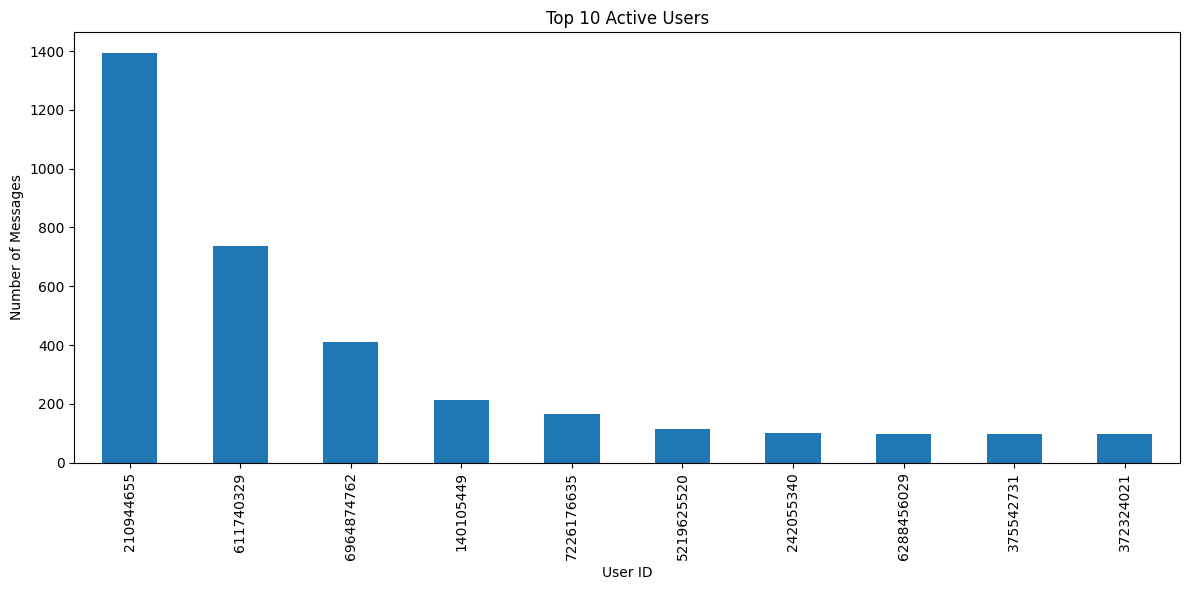


Number of different chats each top user participates in:
from_user
140105449     1
210944655     1
242055340     1
372324021     1
375542731     1
611740329     1
5219625520    1
6288456029    1
6964874762    1
7226176635    1
Name: chat_id, dtype: int64


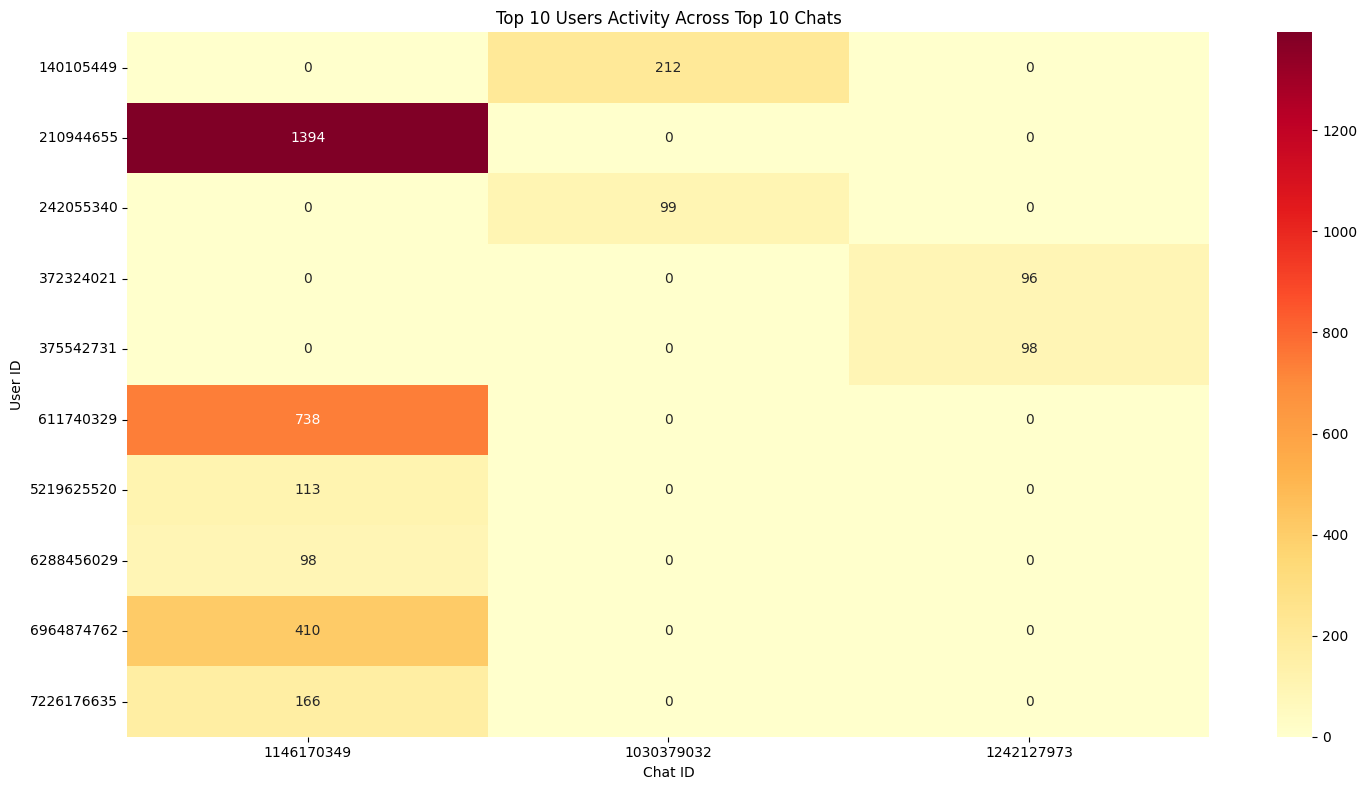


Names of the top 10 most active chats:
Chat ID: 1146170349, Name: Binance English
Chat ID: 1030379032, Name: >>> telegram.Bot()
Chat ID: 1242127973, Name: LobsterDAO ��

Detailed information about top 10 users:
+---------------------------------+-------------+
| User ID                         | 210944655   |
+---------------------------------+-------------+
| Name                            | Combot None |
+---------------------------------+-------------+
| Username                        | combot      |
+---------------------------------+-------------+
| Total messages                  | 1394        |
+---------------------------------+-------------+
| Number of chats participated in | 1           |
+---------------------------------+-------------+

Top 3 most active chats:
+------------+--------------------+------------+
|    Chat ID | Chat Name          |   Messages |
+============+====================+============+
| 1146170349 | Binance English    |       1394 |
+------------+--

In [4]:

# Function to normalize chat IDs
def normalize_chat_id(chat_id):
    chat_id_str = str(chat_id)
    if chat_id_str.startswith('-100'):
        return int(chat_id_str[4:])
    return int(chat_id)

# Normalize chat IDs in chat_history_df
chat_history_df['chat_id'] = chat_history_df['chat_id'].apply(normalize_chat_id)

# Normalize chat IDs in chat_info_df
chat_info_df['id'] = chat_info_df['id'].apply(normalize_chat_id)

# Get top 10 active users
top_users = chat_history_df['from_user'].value_counts().head(10)

# Plot top 10 active users
plt.figure(figsize=(12, 6))
top_users.plot(kind='bar')
plt.title('Top 10 Active Users')
plt.xlabel('User ID')
plt.ylabel('Number of Messages')
plt.tight_layout()
plt.show()

# Analyze user participation across different chats
user_chat_participation = chat_history_df[chat_history_df['from_user'].isin(top_users.index)]
user_chat_counts = user_chat_participation.groupby('from_user')['chat_id'].nunique().sort_values(ascending=False)

print("\nNumber of different chats each top user participates in:")
print(user_chat_counts)

# Create a heatmap of user activity across chats
user_chat_activity = user_chat_participation.groupby(['from_user', 'chat_id']).size().unstack(fill_value=0)
user_chat_activity = user_chat_activity.reindex(columns=user_chat_activity.sum().sort_values(ascending=False).index)

plt.figure(figsize=(15, 8))
sns.heatmap(user_chat_activity.iloc[:, :10], annot=True, fmt='d', cmap='YlOrRd')
plt.title('Top 10 Users Activity Across Top 10 Chats')
plt.xlabel('Chat ID')
plt.ylabel('User ID')
plt.tight_layout()
plt.show()

# Get chat names for the top 10 chats
top_10_chats = user_chat_activity.sum().sort_values(ascending=False).head(10).index
chat_names = chat_info_df[chat_info_df['id'].isin(top_10_chats)].set_index('id')['name']

print("\nNames of the top 10 most active chats:")
for chat_id in top_10_chats:
    print(f"Chat ID: {chat_id}, Name: {chat_names.get(chat_id, 'Unknown')}")

# Get user info for top 10 users
top_user_info = user_info_df[user_info_df['id'].isin(top_users.index)].set_index('id')

print("\nDetailed information about top 10 users:")

for user_id in top_users.index:
    user = top_user_info.loc[user_id]
    
    # User info table
    user_info = [
        ["User ID", user_id],
        ["Name", f"{user['first_name']} {user['last_name']}"],
        ["Username", user['username']],
        ["Total messages", top_users[user_id]],
        ["Number of chats participated in", user_chat_counts[user_id]]
    ]
    print(tabulate(user_info, tablefmt="grid"))
    
    # Top 3 chats table
    print("\nTop 3 most active chats:")
    top_3_chats = user_chat_activity.loc[user_id].sort_values(ascending=False).head(3)
    chat_info = [
        [chat_id, chat_names.get(chat_id, 'Unknown'), message_count]
        for chat_id, message_count in top_3_chats.items()
    ]
    print(tabulate(chat_info, headers=["Chat ID", "Chat Name", "Messages"], tablefmt="grid"))
    
    print("\n" + "="*50 + "\n")  # Separator between users

# Print unique chat IDs after normalization
print("\nUnique chat IDs after normalization:")
print(chat_history_df['id'].unique())

Message lenght destribution

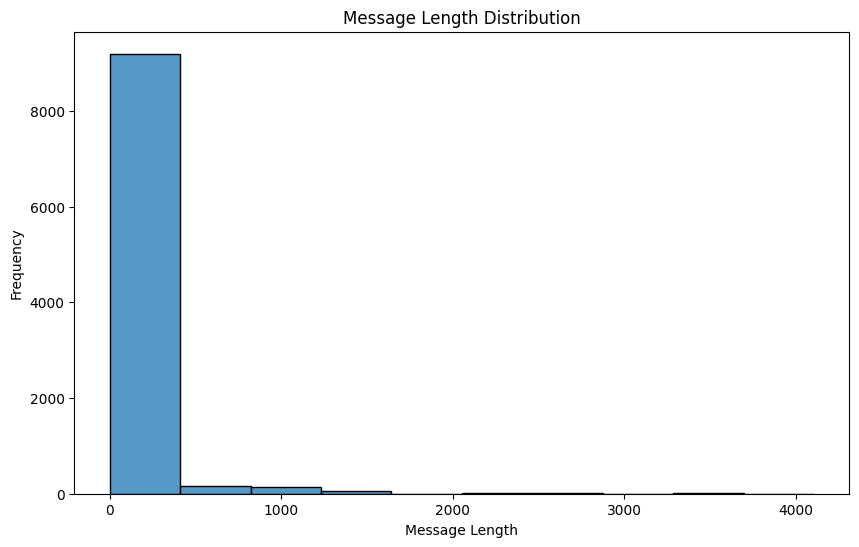

In [5]:
chat_history_df['message_length'] = chat_history_df['text'].astype(str).str.len()
plt.figure(figsize=(10, 6))
sns.histplot(chat_history_df['message_length'], bins=10, kde=False)
plt.title('Message Length Distribution')
plt.xlabel('Message Length')
plt.ylabel('Frequency')
plt.show()

Word cloud for all massages


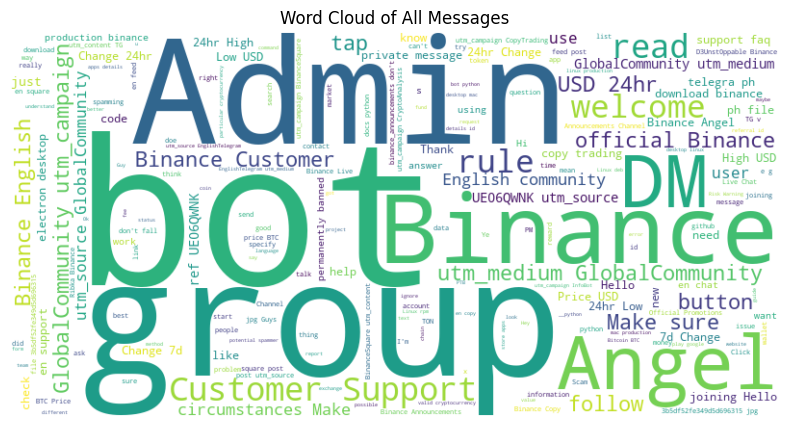

In [6]:
all_text = ' '.join(chat_history_df['text'].astype(str))
stopwords = set(CountVectorizer(stop_words='english').get_stop_words())
stopwords = stopwords.union(set(['http', 'https', 'www', 'com', 'org', 'net', 'telegram', 't', 'com']))
wordcloud = WordCloud(width=800, height=400, background_color='white',stopwords=stopwords).generate(all_text)


plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of All Messages')
plt.show()

User engagement summary -- something here i am not handeling right

In [7]:
import numpy as np
import pandas as pd

# Assuming chat_history_df is your DataFrame

def is_valid(value):
    if pd.isna(value):
        return False
    if isinstance(value, (int, float)):
        return value != 0
    if isinstance(value, str):
        return value.strip() != '' and value != '0'
    return True

# Apply the is_valid function to relevant columns
columns_to_check = ['views', 'forwards', 'reactions', 'media']
for col in columns_to_check:
    chat_history_df[f'{col}_valid'] = chat_history_df[col].apply(is_valid)

# Aggregate user engagement statistics
user_engagement = chat_history_df.groupby('from_user').agg({
    'id': 'count',              # Total messages
    'media_valid': 'sum',       # Count of messages with valid media
    'reactions_valid': 'sum',   # Count of messages with valid reactions
    'views_valid': 'sum',       # Count of messages with valid views
    'forwards_valid': 'sum',    # Count of messages with valid forwards
    'views': lambda x: x[x != 0].mean()  # Average views (excluding zeros)
}).reset_index()

# Rename columns for clarity
user_engagement.columns = [
    'user_id',
    'total_messages',
    'media_messages',
    'messages_with_reactions',
    'messages_with_views',
    'messages_with_forwards',
    'avg_views'
]

print("\nUser Engagement Summary:")
print(user_engagement.describe())

# Optional: Print the first few rows to verify
print("\nFirst few rows of User Engagement:")
print(user_engagement.head())


User Engagement Summary:
                 user_id  total_messages  media_messages  \
count             1818.0     1818.000000     1818.000000   
mean   3789502008.838834        5.276128        0.459296   
std    2749844227.104328       39.489947        7.551893   
min             355676.0        1.000000        0.000000   
25%        1006552195.25        1.000000        0.000000   
50%         5123053956.5        1.000000        0.000000   
75%         6463938351.0        3.000000        0.000000   
max         7499392850.0     1394.000000      281.000000   

       messages_with_reactions  messages_with_views  messages_with_forwards  
count              1818.000000          1818.000000             1818.000000  
mean                  0.612211             0.006601                0.006601  
std                   2.892460             0.128324                0.128324  
min                   0.000000             0.000000                0.000000  
25%                   0.000000             

Actvivity heatmap

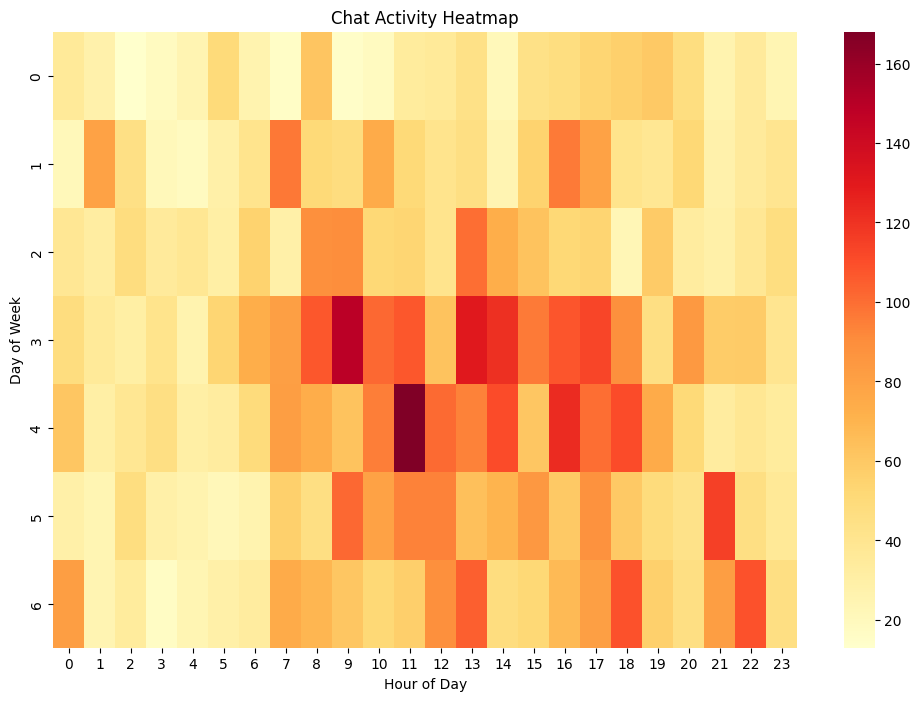

In [8]:
chat_history_df['hour'] = chat_history_df['date'].dt.hour
chat_history_df['day_of_week'] = chat_history_df['date'].dt.dayofweek

activity_heatmap = chat_history_df.groupby(['day_of_week', 'hour']).size().unstack()

plt.figure(figsize=(12, 8))
sns.heatmap(activity_heatmap, cmap='YlOrRd')
plt.title('Chat Activity Heatmap')
plt.xlabel('Hour of Day')
plt.ylabel('Day of Week')
plt.show()

Destribution of a bot users

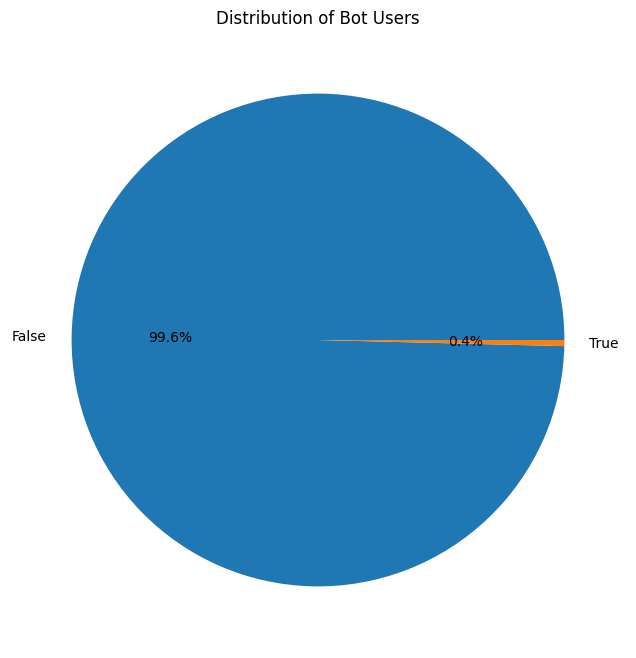

In [9]:
bot_users = user_info_df['bot'].value_counts()
plt.figure(figsize=(8, 8))
bot_users.plot(kind='pie', autopct='%1.1f%%')
plt.title('Distribution of Bot Users')
plt.ylabel('')
plt.show()

Moste active chats


Top 10 Most Active Chats:
                 name  message_count
0     Binance English           6264
1  >>> telegram.Bot()           1720
2       LobsterDAO ��           1614


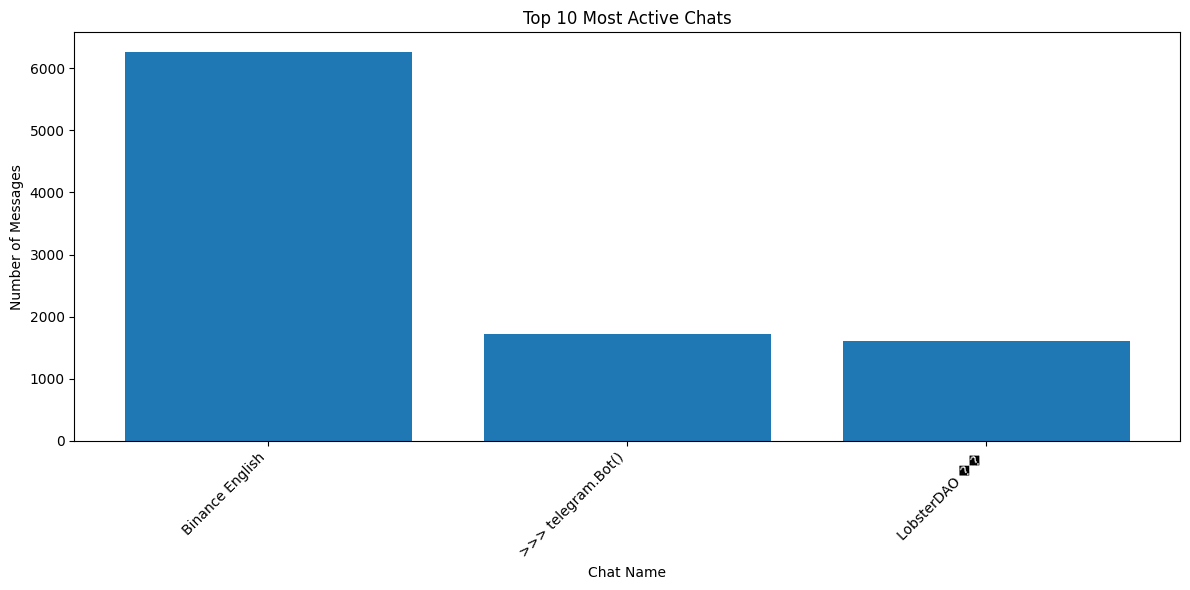

In [10]:

# Remove the '-100' prefix from chat_id in chat_history_df
chat_history_df['chat_id'] = chat_history_df['chat_id'].apply(lambda x: str(x)[4:] if str(x).startswith('-100') else str(x)).astype(int)

# Count the messages for each chat
chat_counts = chat_history_df['chat_id'].value_counts().reset_index()
chat_counts.columns = ['id', 'message_count']

# Merge chat_counts with chat_info_df to get the chat names
chat_counts_with_names = pd.merge(chat_counts, chat_info_df[['id', 'name']], on='id', how='left')

# Sort by message count and get top 10
top_chats = chat_counts_with_names.sort_values('message_count', ascending=False).head(10)

# Print the results
print("\nTop 10 Most Active Chats:")
print(top_chats[['name', 'message_count']])

# Create a bar plot
plt.figure(figsize=(12, 6))
plt.bar(top_chats['name'], top_chats['message_count'])
plt.title('Top 10 Most Active Chats')
plt.xlabel('Chat Name')
plt.ylabel('Number of Messages')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

Registration order -- probably useless or maybe different presentation

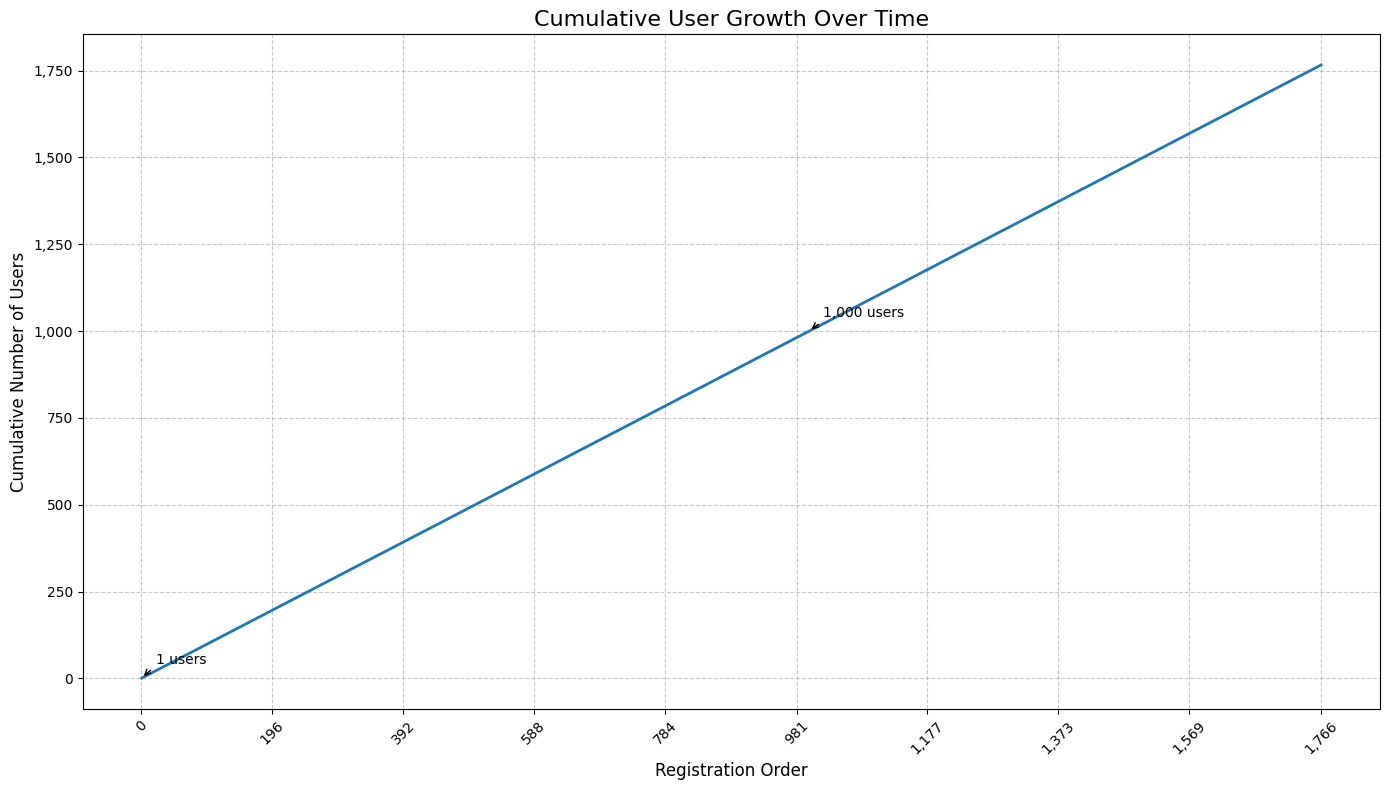

In [11]:
#This line is creating the registration order based on the 'id' column in your user_info_df. Here's what it does:
#It uses the rank() function on the 'id' column.
#The method='first' parameter assigns ranks to the IDs in the order they appear, with ties being resolved by giving the first occurrence the lower rank.

user_info_df = user_info_df.sort_values('id')

# Create registration order
user_info_df['registration_order'] = range(1, len(user_info_df) + 1)

# Calculate the cumulative number of users
user_info_df['cumulative_users'] = range(1, len(user_info_df) + 1)

# Set up the plot style
plt.style.use('default')
fig, ax = plt.subplots(figsize=(14, 8))

# Plot the data
ax.plot(user_info_df['registration_order'], user_info_df['cumulative_users'], linewidth=2)

# Customize the plot
ax.set_title('Cumulative User Growth Over Time', fontsize=16)
ax.set_xlabel('Registration Order', fontsize=12)
ax.set_ylabel('Cumulative Number of Users', fontsize=12)

# Add grid for better readability
ax.grid(True, linestyle='--', alpha=0.7)

# Improve x-axis ticks
max_order = user_info_df['registration_order'].max()
tick_positions = np.linspace(0, max_order, 10, dtype=int)
ax.set_xticks(tick_positions)
ax.set_xticklabels([f'{x:,}' for x in tick_positions], rotation=45)

# Improve y-axis ticks
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: format(int(x), ',')))

# Add annotations for important milestones
milestones = [1, 1000, 10000, 100000]
for milestone in milestones:
    if milestone <= max_order:
        milestone_data = user_info_df.loc[user_info_df['registration_order'] >= milestone].iloc[0]
        ax.annotate(f'{milestone:,} users', 
                    xy=(milestone_data['registration_order'], milestone_data['cumulative_users']),
                    xytext=(10, 10), textcoords='offset points',
                    arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0.2'))

plt.tight_layout()
plt.show()

## Sentimental and emotional analysis of group texts

In [12]:
# Download necessary NLTK data
nltk.download('punkt')
nltk.download('stopwords')

# Function to download NRC Emotion Lexicon
def download_nrc_lexicon():
    url = "https://raw.githubusercontent.com/dinbav/LeXmo/master/NRC-Emotion-Lexicon-Wordlevel-v0.92.txt"
    response = requests.get(url)
    lines = response.text.split("\n")
    lexicon = {}
    for line in lines:
        parts = line.strip().split("\t")
        if len(parts) == 3:
            word, emotion, value = parts
            if word not in lexicon:
                lexicon[word] = {}
            lexicon[word][emotion] = int(value)
    return lexicon

# Download the NRC Emotion Lexicon
nrc_lexicon = download_nrc_lexicon()

# Function to get emotions from text
def get_emotions(text):
    if pd.isna(text) or not isinstance(text, str):
        return Counter()
    words = nltk.word_tokenize(text.lower())
    emotions = Counter()
    for word in words:
        if word in nrc_lexicon:
            emotions.update({emotion: score for emotion, score in nrc_lexicon[word].items() if score > 0})
    return emotions

# Function to get sentiment
def get_sentiment(text):
    if pd.isna(text) or not isinstance(text, str):
        return 0
    return TextBlob(text).sentiment.polarity

[nltk_data] Downloading package punkt to /Users/ajda/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/ajda/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Average Sentiment: 0.08


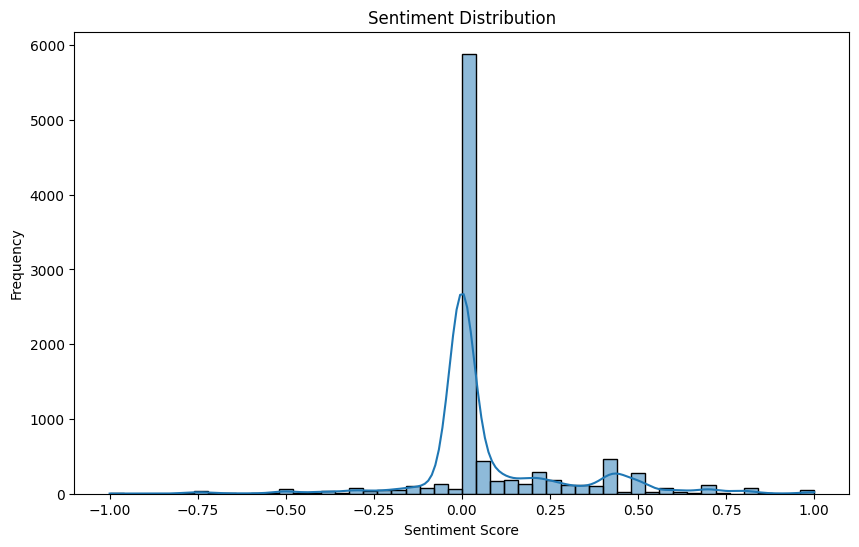

In [13]:
# Perform sentiment and emotion analysis
chat_history_df['sentiment'] = chat_history_df['text'].apply(get_sentiment)
chat_history_df['emotions'] = chat_history_df['text'].apply(get_emotions)

# Calculate average sentiment
avg_sentiment = chat_history_df['sentiment'].mean()
print(f"Average Sentiment: {avg_sentiment:.2f}")

# Plot sentiment distribution
plt.figure(figsize=(10, 6))
sns.histplot(chat_history_df['sentiment'], bins=50, kde=True)
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')
plt.show()

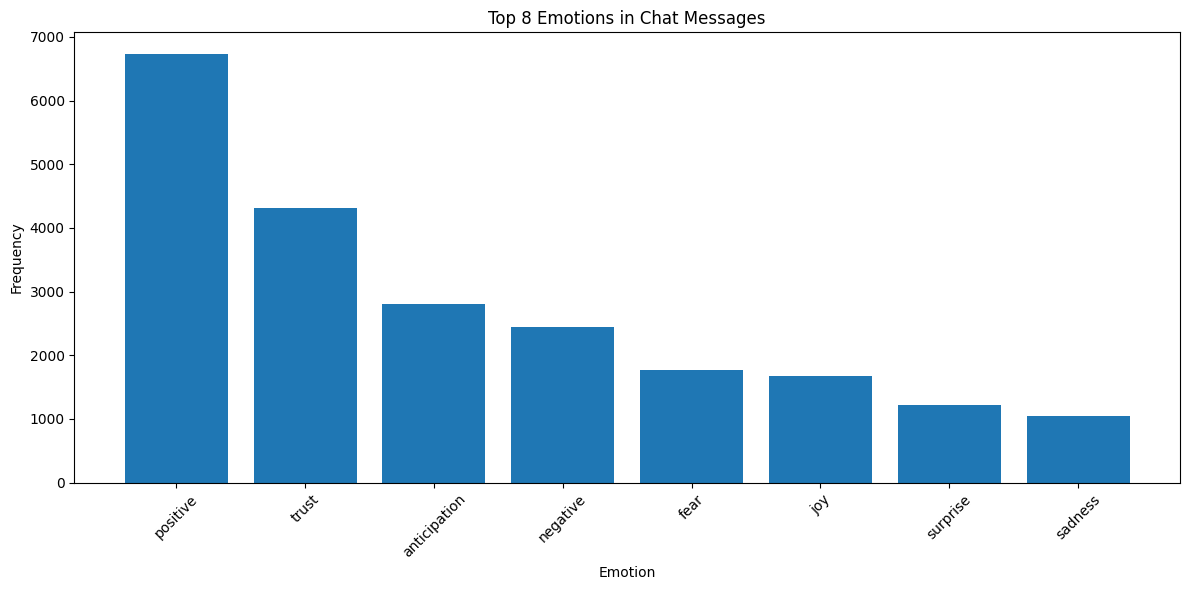

In [14]:
# Aggregate emotions across all messages
all_emotions = Counter()
for emotions in chat_history_df['emotions']:
    all_emotions.update(emotions)

# Plot top emotions
top_emotions = dict(all_emotions.most_common(8))
plt.figure(figsize=(12, 6))
plt.bar(top_emotions.keys(), top_emotions.values())
plt.title('Top 8 Emotions in Chat Messages')
plt.xlabel('Emotion')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

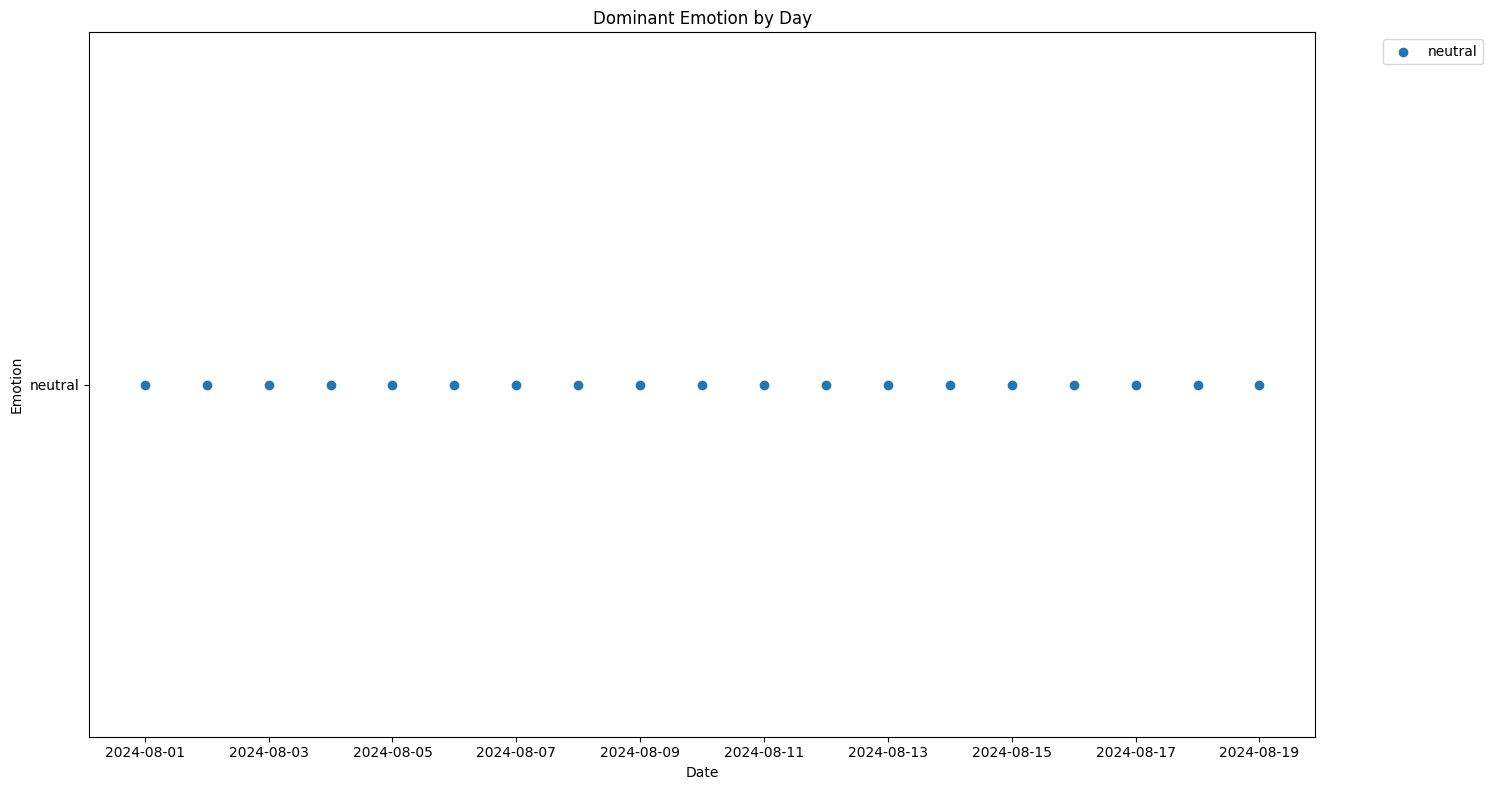

In [15]:
# Emotion over time analysis
chat_history_df['date'] = pd.to_datetime(chat_history_df['date'])
chat_history_df = chat_history_df.set_index('date')

# Function to get the dominant emotion
def get_dominant_emotion(emotions):
    return max(emotions, key=emotions.get) if emotions else 'neutral'

chat_history_df['dominant_emotion'] = chat_history_df['emotions'].apply(get_dominant_emotion)

# Resample by day and get the most common emotion
daily_emotion = chat_history_df['dominant_emotion'].resample('D').agg(lambda x: x.value_counts().index[0] if len(x) > 0 else 'neutral')

# Plot emotions over time
plt.figure(figsize=(15, 8))
for emotion in set(daily_emotion.values):
    emotion_days = daily_emotion[daily_emotion == emotion].index
    plt.scatter(emotion_days, [emotion] * len(emotion_days), label=emotion)

plt.title('Dominant Emotion by Day')
plt.xlabel('Date')
plt.ylabel('Emotion')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

Correlation between sentiment and message length: 0.09


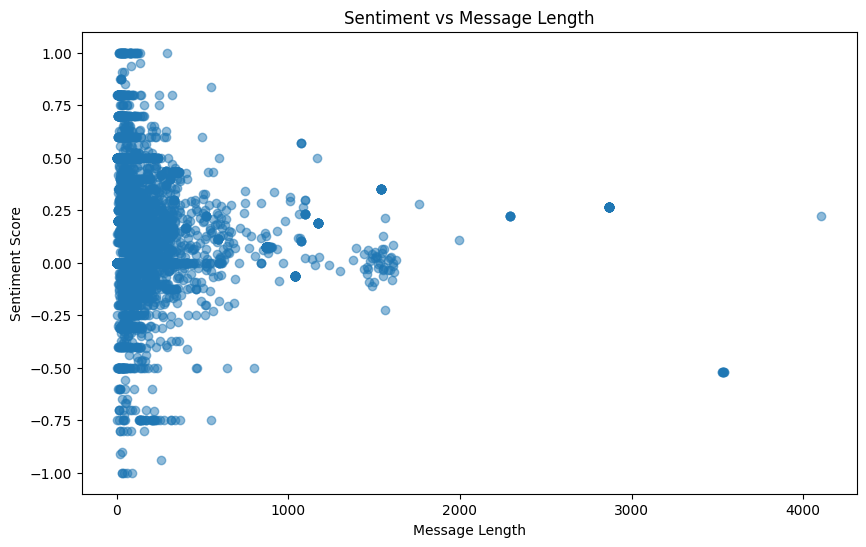

In [16]:
# Correlation between sentiment and message length
#The correlation value ranges from -1 to 1, where -1 represents a strong negative correlation,
#0 represents no correlation, and 1 represents a strong positive correlation.
chat_history_df['message_length'] = chat_history_df['text'].fillna('').astype(str).str.len()
correlation = chat_history_df['sentiment'].corr(chat_history_df['message_length'])
print(f"Correlation between sentiment and message length: {correlation:.2f}")

plt.figure(figsize=(10, 6))
plt.scatter(chat_history_df['message_length'], chat_history_df['sentiment'], alpha=0.5)
plt.title('Sentiment vs Message Length')
plt.xlabel('Message Length')
plt.ylabel('Sentiment Score')
plt.show()

In [17]:
# Emotion analysis for top users
top_users = chat_history_df['from_user'].value_counts().head(5).index
for user in top_users:
    user_emotions = Counter()
    for emotions in chat_history_df[chat_history_df['from_user'] == user]['emotions']:
        user_emotions.update(emotions)
    
    print(f"\nTop 5 emotions for user {user}:")
    print(dict(user_emotions.most_common(5)))


Top 5 emotions for user 210944655:
{'positive': 2272, 'trust': 1433, 'anticipation': 616, 'joy': 462, 'negative': 427}

Top 5 emotions for user 611740329:
{'positive': 199, 'trust': 166, 'anticipation': 135, 'negative': 79, 'joy': 47}

Top 5 emotions for user 6964874762:
{'fear': 714, 'positive': 259, 'anticipation': 256, 'negative': 211, 'trust': 146}

Top 5 emotions for user 140105449:
{'positive': 53, 'negative': 31, 'trust': 21, 'anticipation': 20, 'fear': 19}

Top 5 emotions for user 7226176635:
{'positive': 85, 'trust': 53, 'anticipation': 39, 'negative': 25, 'joy': 12}


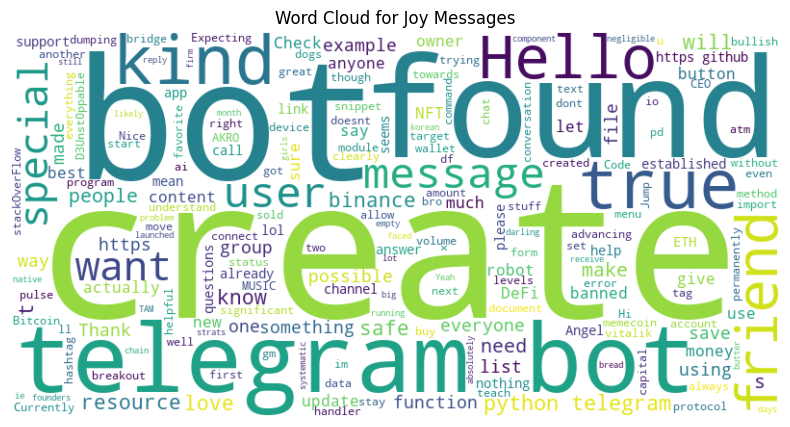

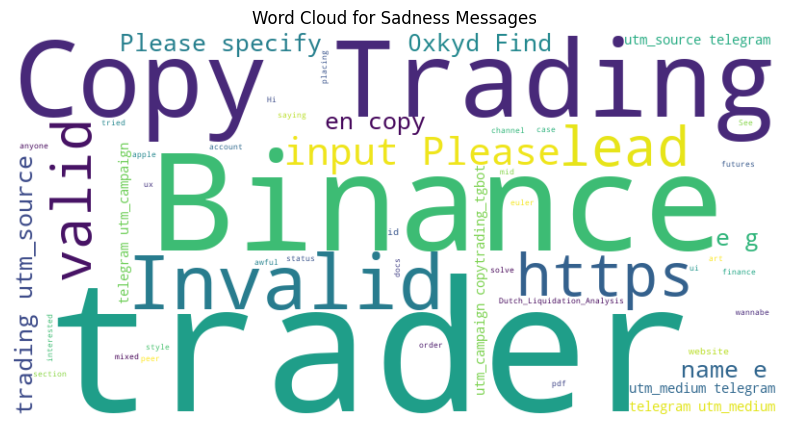

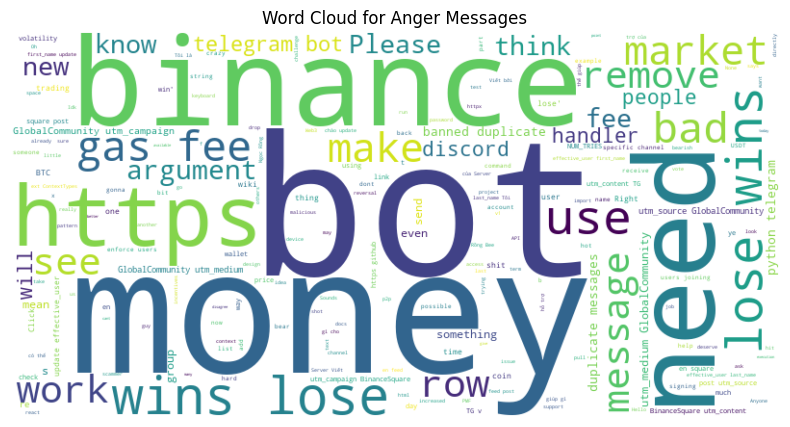

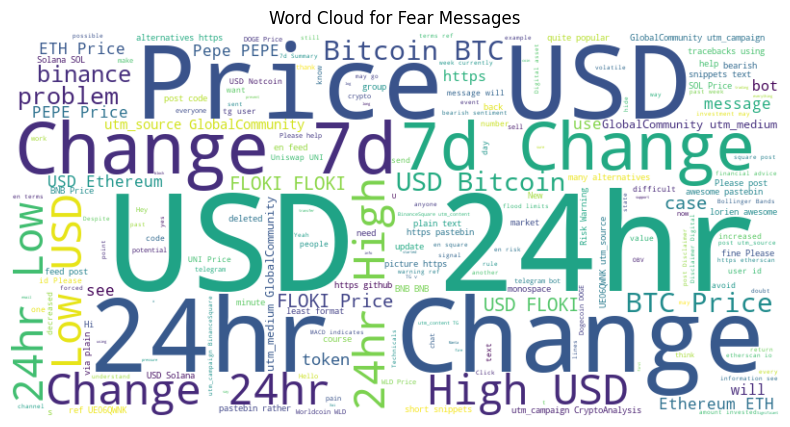

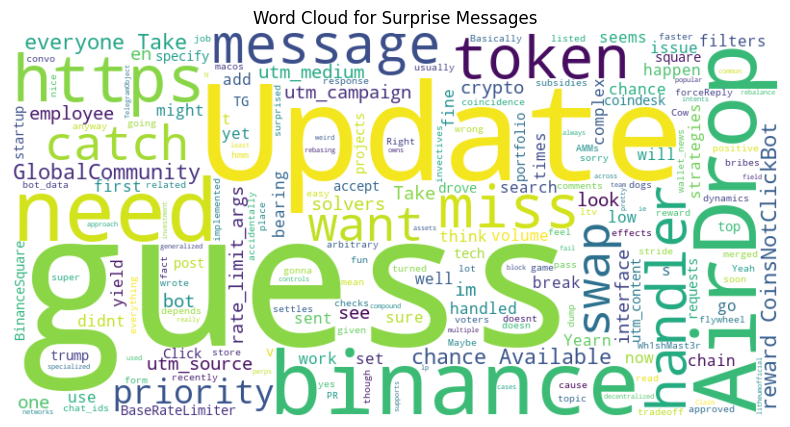

In [18]:
# Word cloud for each emotion

for emotion in ['joy', 'sadness', 'anger', 'fear', 'surprise']:
    emotion_words = ' '.join(chat_history_df[chat_history_df['dominant_emotion'] == emotion]['text'].fillna('').astype(str))
    if emotion_words.strip():  # Check if there are any words for this emotion
        wordcloud = WordCloud(width=800, height=400, background_color='white').generate(emotion_words)
        
        plt.figure(figsize=(10, 5))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis('off')
        plt.title(f'Word Cloud for {emotion.capitalize()} Messages')
        plt.show()
    else:
        print(f"No words found for emotion: {emotion}")

## User analysis

  Country Code  Count
0          796      1
1          628      1
2          249      1
3          251      1
4          186      1
5          880      1
6          888      1
7          923      1
8          968      1
9          964      1


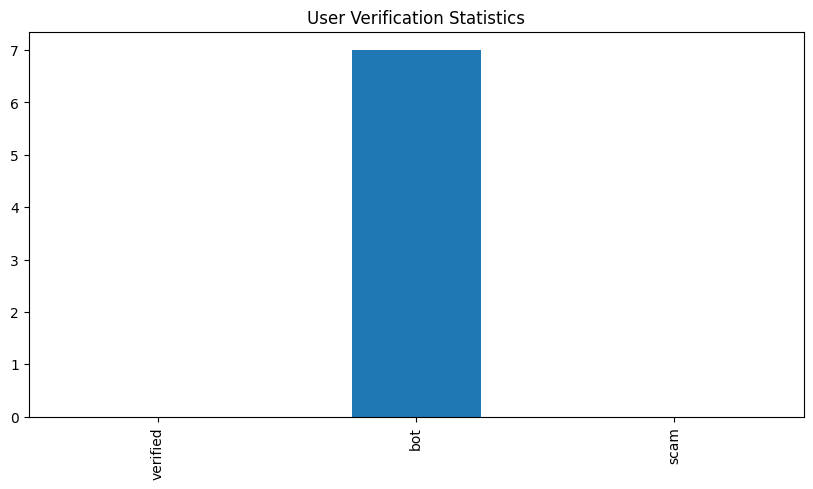

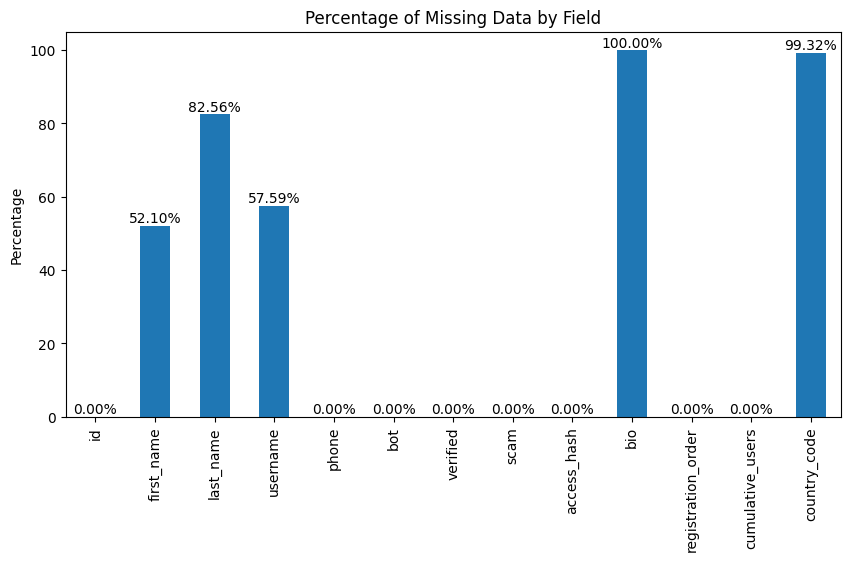

Percentage of bots: 0.40%


In [19]:
# 3. Contact Information Analysis
def get_country_code(phone):
    if pd.notnull(phone) and phone != 0:
        return str(int(phone))[:3]
    return None

user_info_df['country_code'] = user_info_df['phone'].apply(get_country_code)

# Count all non-zero country codes
country_code_counts = user_info_df['country_code'].count()

top_country_codes = user_info_df['country_code'].value_counts().head(10)
top_country_codes_table = pd.DataFrame({'Country Code': top_country_codes.index, 'Count': top_country_codes.values})
print(top_country_codes_table)


# 4. User Verification and Trust
verification_stats = user_info_df[['verified', 'bot', 'scam']].sum()
plt.figure(figsize=(10, 5))
verification_stats.plot(kind='bar')
plt.title('User Verification Statistics')
plt.show()

# 6. Data Quality and Completeness
missing_data = user_info_df.isnull().sum() / len(user_info_df) * 100
plt.figure(figsize=(10, 5))
ax = missing_data.plot(kind='bar')
plt.title('Percentage of Missing Data by Field')
plt.ylabel('Percentage')

# Add percentage on top of each bar
for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}%', (p.get_x() + p.get_width() / 2, p.get_height()), ha='center', va='bottom')

plt.show()


# 7. Bot Detection and Analysis
bot_percentage = (user_info_df['bot'].sum() / len(user_info_df)) * 100
print(f"Percentage of bots: {bot_percentage:.2f}%")